In [1]:
%load_ext autoreload
%autoreload 2 

* 이미지를 VAE로 Embedding하여 얻은 vector의 similarity와 풍속데이터의 Similarity 비교
* 체크해야 할 것
    - 풍속기록이 있는 데이터만 필요하며, 일부는 Train 일부는 test 이를 구분해야 할 필요가 있음

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import yaml
import torch
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset

from src.hillshpaeDataModule import MySimCLRTrainDataTransform
from simCLR import *
from src import *

In [3]:
# Wind data load

with open('../../Share_Data/windspeed/_Main_dataset.pickle', 'rb') as f:
    windspeed_dataset = pickle.load(f)

station_list = list(windspeed_dataset.keys())
windspeed_list = []
for item in windspeed_dataset.values():
    windspeed_list.append(item[3])
windspeed_list = np.array(windspeed_list)

In [4]:
# load config
config_path = 'configs/simclr_rgb.yaml'
checkpoint_path = '../../Share_Data/logs/SimCLR_CART/last.ckpt'

with open(config_path, 'rb') as f:
    config = yaml.safe_load(f)

#load vae model
untrained_model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)
model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)

#checkpoint load
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # when using CPU
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
# load img data
IMG_PATH = '../../Share_Data/satellite/jpg_cart_d10/_jpg_cart_d10/{}.jpg'

img_list =[ ]
label_list = []
for station_code in station_list:
    img = Image.open(IMG_PATH.format(station_code)).resize([config['exp_parmas']['img_size']]*2)
    img_list.append(np.array(img))
    label_list.append(station_code)

img_list = (np.array(img_list)/255.)*2-1
tensor_img = torch.Tensor(img_list).permute(0,3,1,2)
tensor_dataset = TensorDataset(tensor_img)
dataloader = DataLoader(tensor_dataset)

In [6]:
model_latent = model.forward(tensor_img)
untrained_latent = untrained_model.forward(tensor_img)

model_projection = model.Projection(model_latent)
untrained_model_projection = untrained_model.Projection(untrained_latent)

print('size of latent : {}'.format(model_latent.size()))
print('size of projection : {}'.format(model_projection.size()))

size of latent : torch.Size([349, 512, 4, 4])
size of projection : torch.Size([349, 32])


---
# Analysis

In [7]:
#windspeed difference matrix

windspeed_diff_list = []
for i in windspeed_list:
    temp_list = []
    for j in windspeed_list:
        temp_list.append(abs(i-j))
    windspeed_diff_list.append(temp_list)
windspeed_diff_list = np.array(windspeed_diff_list)

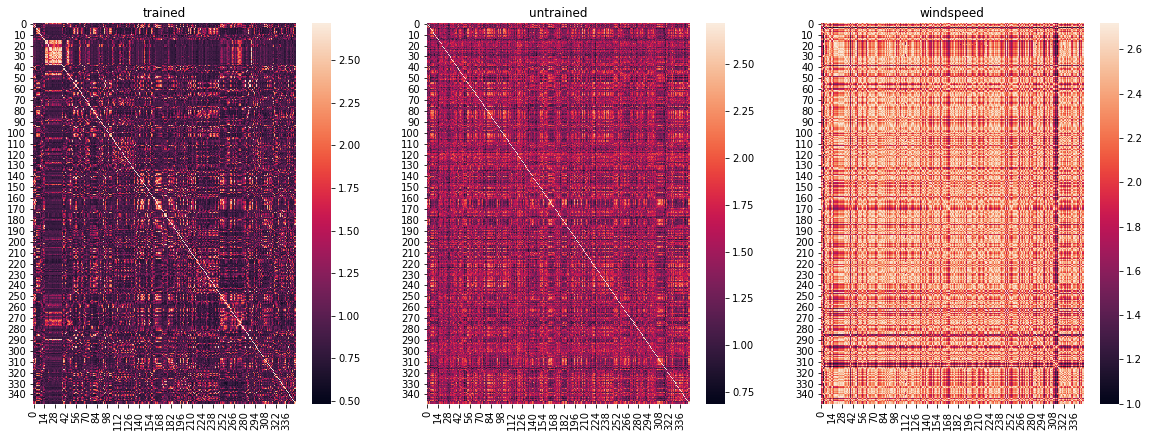

In [8]:
model_n = model_projection.norm(dim=1)[:,None]
model_n = torch.max(model_n, 1e-8*torch.ones_like(model_n))

un_model_n = untrained_model_projection.norm(dim=1)[:, None]
un_model_n = torch.max(un_model_n, 1e-8*torch.ones_like(un_model_n))

cov = torch.mm(model_projection/model_n, (model_projection/model_n).t().contiguous())
sim = torch.exp(cov)
untrained_cov = torch.mm(untrained_model_projection/un_model_n, (untrained_model_projection/un_model_n).t().contiguous())
untrained_sim = torch.exp(untrained_cov)

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(sim.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_sim.detach().numpy())

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff)
plt.show()

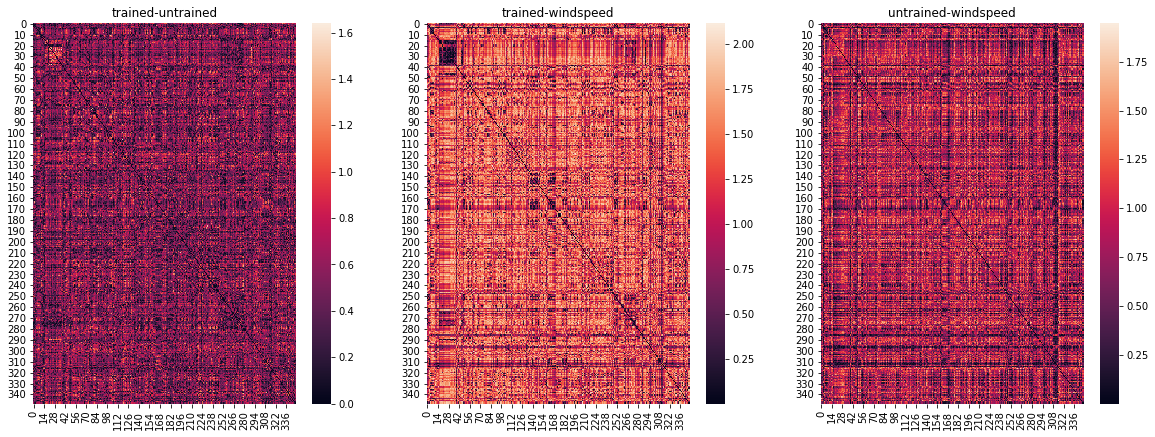

In [9]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained-untrained')
sns.heatmap(abs(sim.detach().numpy()-untrained_sim.detach().numpy()))

plt.subplot(1,3,2)
plt.title('trained-windspeed')
sns.heatmap(abs(sim.detach().numpy()-windspeed_diff))

plt.subplot(1,3,3)
plt.title('untrained-windspeed')
sns.heatmap(abs(untrained_sim.detach().numpy()-windspeed_diff))
plt.show()

## Experiment_01  
* Clustering으로 labeling 비교해보자

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [11]:
with open('../../Share_Data/windspeed/rgb_d5_label.pickle', 'rb') as f:
    label = pickle.load(f)
    
label_pd = pd.DataFrame(label).set_index(0)

In [12]:
select_label = []
for i in list(windspeed_dataset):
    select_label.append(int(label_pd.loc[i][1]))

In [13]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(model_projection.detach().numpy())

* 눈으로 보기엔 4 <- 0 / 2<-2 / 3<-1 인듯

In [17]:
change_list = [4, 3, 2]
kmeans_label = list(map(lambda x:change_list[x], kmeans.labels_))    

In [18]:
select_label = np.array(select_label).reshape(-1,1)
kmeans_label = np.array(kmeans_label).reshape(-1,1)

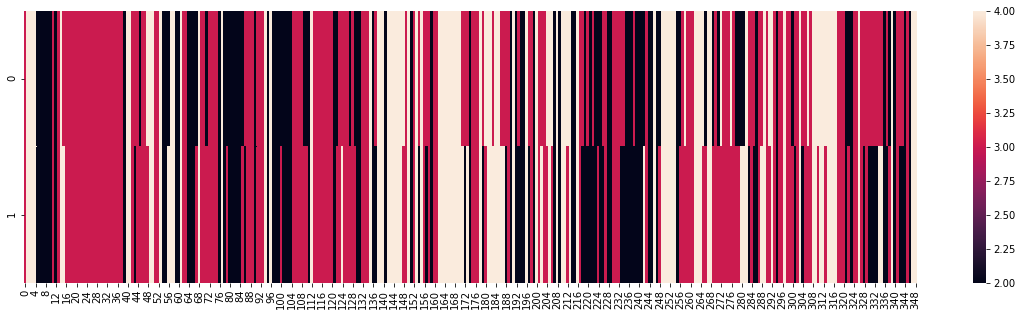

In [19]:
plt.figure(figsize=(20,5))
sns.heatmap(np.concatenate([select_label, kmeans_label], axis=-1).T)
plt.show()

In [20]:
print('difference : {}'.format(sum(select_label != kmeans_label)))

difference : [80]


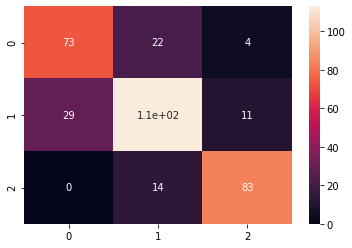

In [21]:
sns.heatmap(confusion_matrix(select_label, kmeans_label), annot=True)
plt.show()

### 나름 의미 있는 결과 같은데,
* RGB와 비교하면 더 좋아진거 같은데...
* 2->4는 뭐지

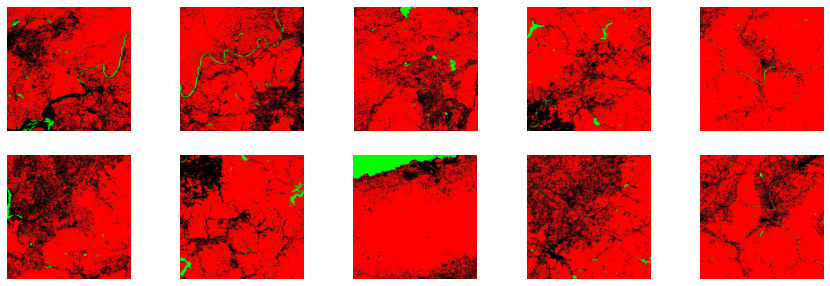

In [24]:
# 휴리스틱하게 2번이라 분류했지만 기계가 1번이라고 답한거 둘러보자

select_inex = np.array(list(windspeed_dataset))[np.ravel((select_label == 3) & (kmeans_label==2))]
Sample_num = 10
row_num = 2
col_num = 5

fig_path = '../../Share_Data/satellite/jpg_cart_d10/_jpg_cart_d10/{}.jpg'

plt.figure(figsize=(15,5))
for index, img_name in enumerate(select_inex[:Sample_num]):
    plt.subplot(row_num, col_num, index+1)
    plt.imshow(Image.open(fig_path.format(img_name)))
    plt.axis('off')
plt.show()

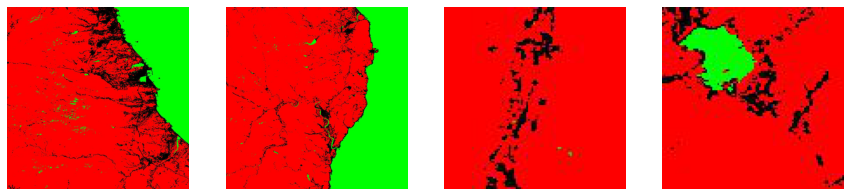

In [27]:
# 2 -> 4

select_inex = np.array(list(windspeed_dataset))[np.ravel((select_label == 2) & (kmeans_label==4))]
Sample_num = 4
row_num = 1
col_num = 4

fig_path = '../../Share_Data/satellite/jpg_cart_d10/_jpg_cart_d10/{}.jpg'

plt.figure(figsize=(15,5))
for index, img_name in enumerate(select_inex[:Sample_num]):
    plt.subplot(row_num, col_num, index+1)
    plt.imshow(Image.open(fig_path.format(img_name)))
    plt.axis('off')
plt.show()

* 2->4 3번째는 뭐지

### Classification 저장

In [30]:
with open('../../Share_Data/windspeed/change_Z_CART.pickle', 'wb') as f:
    pickle.dump(np.concatenate([select_label, kmeans_label], axis=-1),f)

## Experiment_02 
* NN 사용하기 전에 LinearRegression

In [31]:
from sklearn import linear_model
from sklearn.metrics import explained_variance_score

In [32]:
# 위도와 경도 가져오자
place_list = pd.DataFrame(windspeed_dataset).T.iloc[:,0:2].to_numpy().astype(np.float32)
projection = model_projection.detach().numpy()

# 위도 경도 Normalize 하지 않고
total_list = np.concatenate([place_list, projection, np.array(windspeed_list).reshape(-1,1)], axis=-1)

# Random
random_index = np.random.permutation(len(total_list))

In [33]:
# data divide
ratio = 0.2

train_data = total_list[random_index[int(ratio*len(total_list)):]]
test_data = total_list[random_index[:int(ratio*len(total_list))]]

In [34]:
# Training

train_X = train_data[:,:-1]
train_Y = train_data[:,-1]
reg = linear_model.LinearRegression()
reg.fit(train_X, train_Y)

LinearRegression()

In [35]:
reg.coef_

array([ -1.11111057,  -0.148166  ,   8.57130426,   0.4859102 ,
        -1.28522308, -11.9565892 ,  -1.41418413,  13.8240642 ,
         8.43065729,  -9.83559063,   2.83732263, -13.19460783,
        24.00265057,  22.63359457, -15.11018041,  -7.20182799,
        -0.20997808,  -9.63230088,  17.45167094, -11.51987885,
       -18.69553958,   8.91863014, -17.08268503, -11.72860114,
         2.25852139,   1.69605991,  14.75130488, -15.56304222,
         3.90929474,  17.05375518,  -7.3425211 , -15.92633746,
        11.42624317,  13.41961503])

In [36]:
reg.predict(train_X)

array([16.51568646, 14.25765125, 19.61182791, 16.43397107, 21.22776349,
       16.23428785, 15.92464679, 18.28231266, 15.40209166, 18.86117715,
       16.98850601, 16.35195431, 19.40144642, 24.23389408, 16.94977134,
       15.1496145 , 18.82691592, 14.63425001, 17.49736001, 23.07284923,
       18.01466892, 18.9615502 , 20.36922007, 19.38222063, 17.17852485,
       18.29802036, 19.14032352, 16.66346606, 29.48352366, 14.72508846,
       18.02273679, 17.14564381, 15.61251555, 13.91256716, 22.49792958,
       18.8858626 , 23.29739932, 13.61180769, 21.89438905, 23.02910046,
       16.00155384, 18.46345237, 19.70977269, 25.23787979, 21.92363575,
       19.99419991, 22.33058314, 20.56098882, 19.69470358, 21.90071111,
       15.89333954, 18.72938231, 16.0034634 , 19.71311417, 18.00957792,
       20.26986262, 17.98035862, 29.05068318, 14.97275419, 16.88937728,
       19.97953714, 18.38342514, 20.02425066, 17.73636466, 20.22002472,
       15.73985462, 21.65766956, 21.92378262, 13.96640922, 16.76

In [37]:
train_Y

array([10.12362435, 13.13395563, 17.2444669 , 12.6088742 , 21.24047141,
       13.2810308 , 12.09967268, 18.06718268, 22.86641036, 21.9329236 ,
       12.95427628, 19.53635686, 10.24606657, 28.19536992, 13.82946723,
       15.6291244 , 17.43249872, 15.61356777, 18.59357091, 28.15680186,
       17.82959519, 15.99109757, 16.98373558, 22.58111861, 19.69419561,
       19.33593013, 14.56225069, 16.32955359, 24.36812761, 12.88660385,
       17.13147118, 14.47045993, 19.89051143, 17.54424707, 28.08873685,
       20.729993  , 31.68691598, 17.40889048, 22.50149258, 28.67092533,
        9.21300281, 18.83200116, 20.58024991, 22.81012221, 24.31073308,
       20.1695166 , 27.44249454, 32.53037229, 14.08521192, 20.44905806,
       14.79339258, 21.30920175, 15.96148989, 21.54568469, 16.86815867,
       17.19619736, 24.91220854, 26.27963351, 13.39545008, 15.43504138,
       26.84304814, 23.65498452, 19.58873189, 13.56170962, 16.33564689,
       17.3657871 , 17.17651219, 24.30429955, 19.97379629, 14.54

In [38]:
# Predict

test_X = test_data[:,:-1]
test_Y = test_data[:,-1]
reg_result = reg.predict(test_X)

In [39]:
explained_variance_score(test_Y, reg_result)

0.19240309790455956

* 드럽게 안됨

## Experiment_03 
* NN